In [125]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Lambda

In [126]:
# load data
data = pd.read_csv("../0_DataPreparation/Data/model_train_20130701_20180731.csv")

# convert dates
data['Datum'] = pd.to_datetime(data['Datum'])

# examplary inflation rates
inflation_rates = {
    2013: 1.5,
    2014: 1.0,
    2015: 0.5,
    2016: 0.5,
    2017: 1.5,
    2018: 1.9,
    2019: 2.1
}

data['year'] = data['Datum'].dt.year
data['inflation'] = data['year'].map(inflation_rates)

# split data to train and validation set
train_data = data[(data['Datum'] >= '2013-07-01') & (data['Datum'] <= '2017-07-31')]
val_data = data[(data['Datum'] > '2017-07-31') & (data['Datum'] <= '2018-08-31')]

# features 
features = [
    'KielerWoche', 'weekend_or_holiday', 'wetter_sonnig', 'wetter_wolken', 'wetter_regen',
    'wetter_schnee', 'wetter_gewitter', 'wetter_dunst', 'wetter_nebel',
    'temp_bin_Kalt', 'temp_bin_Moderat', 'temp_bin_Warm', 'is_silvester',
    'Monat_April', 'Monat_August', 'Monat_December', 'Monat_February',
    'Monat_January', 'Monat_July', 'Monat_June', 'Monat_March', 'Monat_May',
    'Monat_November', 'Monat_October', 'Monat_September', 'inflation'
]

# target (Umsatz)
target = 'Umsatz'

# scale data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[features + [target]])
val_scaled = scaler.transform(val_data[features + [target]])

scale_factor = 1  # Beispiel: Skaliere Werte hoch


# split feature and target
x_train = train_scaled[:, :-1]  # all columns except Umsatz
y_train = train_scaled[:, -1] * scale_factor  # last column: Umsatz

x_val = val_scaled[:, :-1]
y_val = val_scaled[:, -1] * scale_factor

In [139]:
tf.keras.backend.clear_session()

# create model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(len(features),)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1),  # Keine Aktivierungsfunktion im Output
    Lambda(lambda x: x * 10)  # Skaliert die Ausgabe um den Faktor 10
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='log_cosh',  # Alternativ: 'Huber' oder 'mse'
    metrics=['mae']
)

# training
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)


history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=500,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# evaluation
val_loss, val_mae = model.evaluate(x_val, y_val)
print(f'Validation Loss: {val_loss}, Validation MAE: {val_mae}')


Epoch 1/500


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.3314 - mae: 3.9418 - val_loss: 0.2780 - val_mae: 0.6568
Epoch 2/500
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3287 - mae: 0.7138 - val_loss: 0.0502 - val_mae: 0.2502
Epoch 3/500
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0606 - mae: 0.2661 - val_loss: 0.0101 - val_mae: 0.1019
Epoch 4/500
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0166 - mae: 0.1201 - val_loss: 0.0036 - val_mae: 0.0664
Epoch 5/500
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0088 - mae: 0.0875 - val_loss: 0.0028 - val_mae: 0.0595
Epoch 6/500
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0057 - mae: 0.0752 - val_loss: 0.0026 - val_mae: 0.0578
Epoch 7/500
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0048 - mae: 0.0697 - val_loss: 0.0025 - val_mae: 0.0571
Epoch 8/500
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0040 - mae: 0.0660 - val_loss: 0.0025 - val_mae: 0.0573
Epoch 9/500
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss:

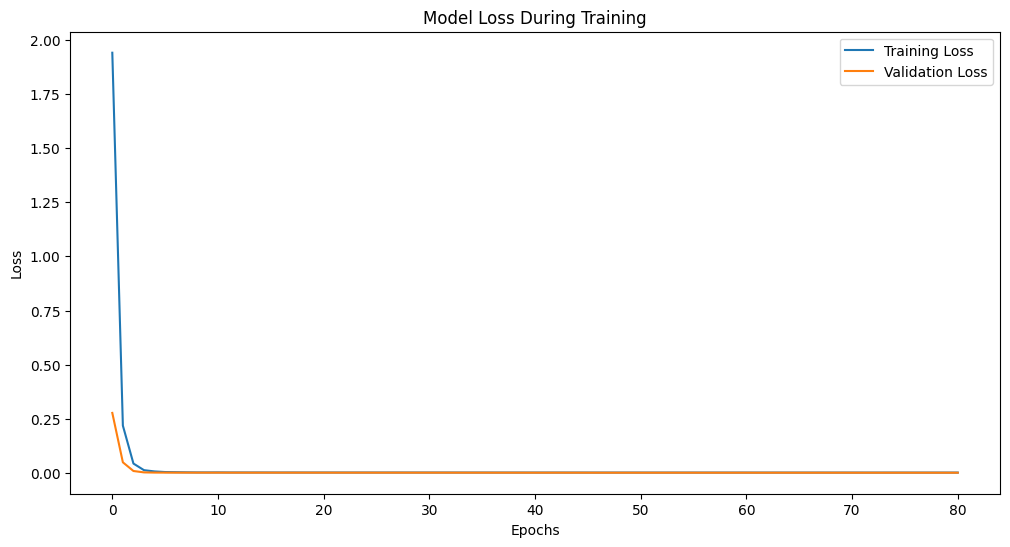

In [140]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [141]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

training_predictions = model.predict(x_train) / scale_factor
validation_predictions = model.predict(x_val) / scale_factor
print(f"MAPE on the Training Data: {mape(y_train, training_predictions):.2f}%")
print(f"MAPE on the Validation Data: {mape(y_val, validation_predictions):.2f}%")

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAPE on the Training Data: 101.04%
MAPE on the Validation Data: 96.41%


In [142]:
# Zurückskalieren der Werte
train_predictions_rescaled = scaler.inverse_transform(
    np.hstack([x_train, training_predictions])  # Kombiniere Features und Vorhersagen
)[:, -1]  # Nimm die Umsatz-Spalte (letzte Spalte)

validation_predictions_rescaled = scaler.inverse_transform(
    np.hstack([x_val, validation_predictions])
)[:, -1]

y_train_rescaled = scaler.inverse_transform(
    np.hstack([x_train, y_train.reshape(-1, 1)])
)[:, -1] / scale_factor

y_val_rescaled = scaler.inverse_transform(
    np.hstack([x_val, y_val.reshape(-1, 1)])
)[:, -1] / scale_factor

# DataFrames für Plots aktualisieren
train_predictions_df = pd.DataFrame({
    'Datum': train_data['Datum'],
    'Tatsächlicher Umsatz': y_train_rescaled.flatten(),
    'Vorhergesagter Umsatz': train_predictions_rescaled.flatten()
})

val_predictions_df = pd.DataFrame({
    'Datum': val_data['Datum'],
    'Tatsächlicher Umsatz': y_val_rescaled.flatten(),
    'Vorhergesagter Umsatz': validation_predictions_rescaled.flatten()
})

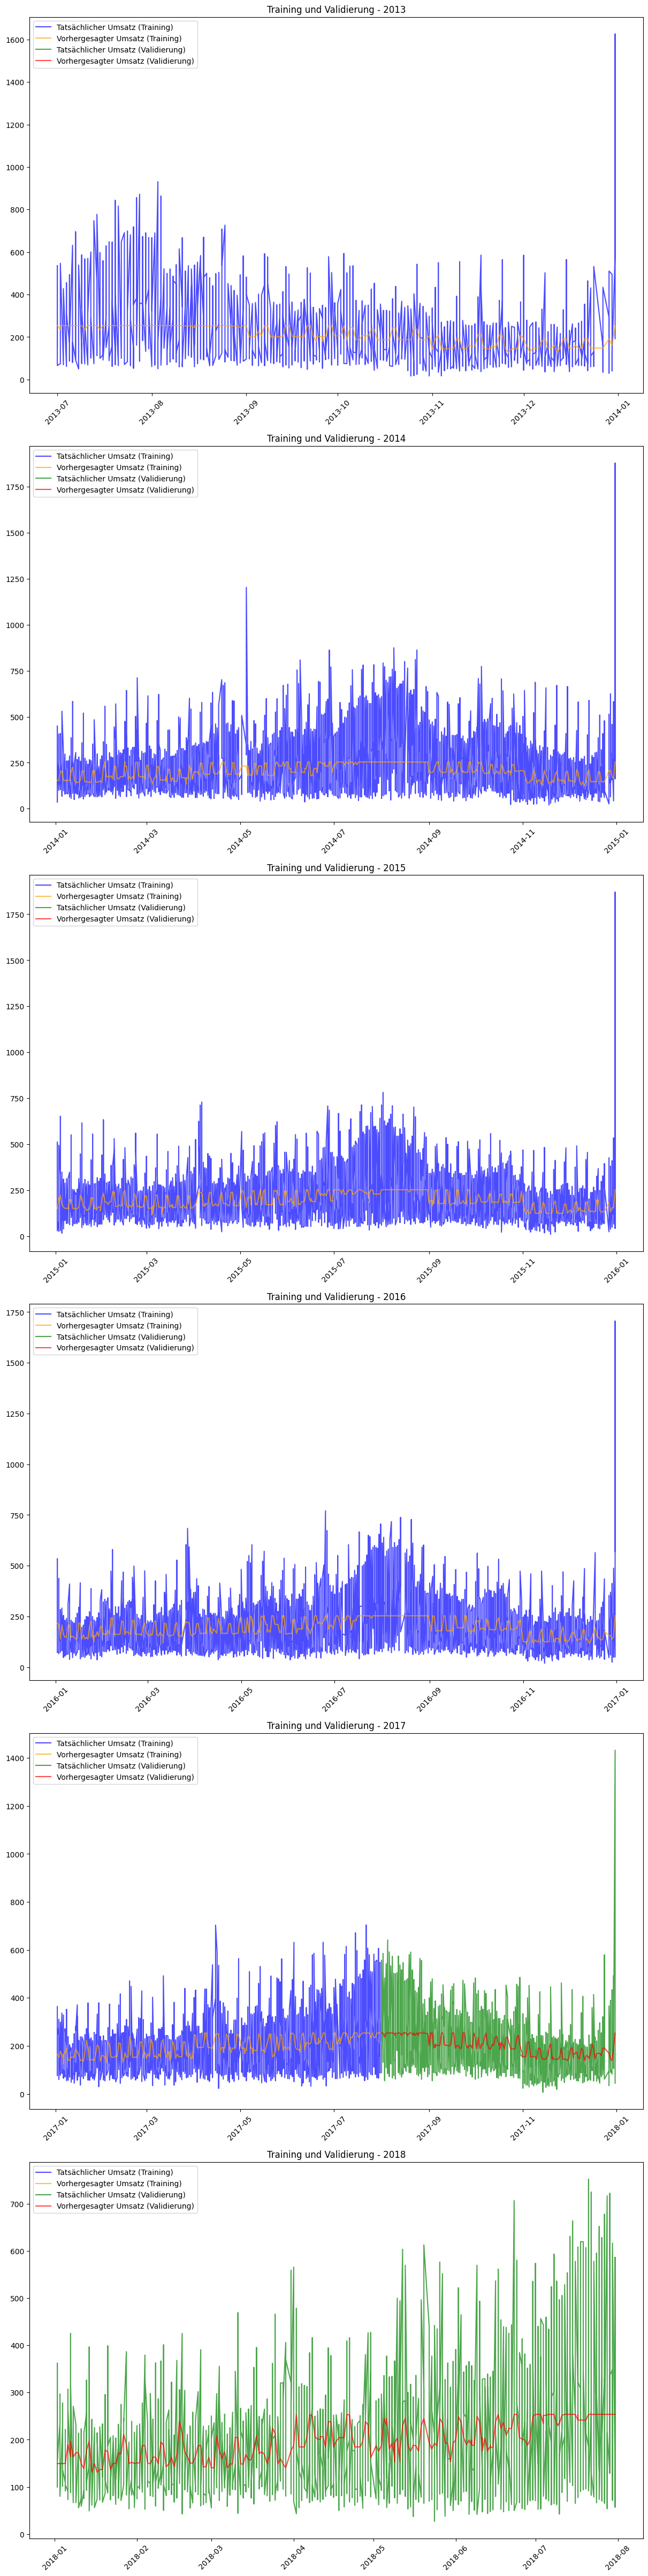

In [143]:
train_predictions_df = train_predictions_df.sort_values(by='Datum')
val_predictions_df = val_predictions_df.sort_values(by='Datum')

# Funktion zur Erstellung der Subplots
def plot_yearly_subplots(data_train, data_val, title, figsize=(12, 8)):
    years_train = data_train['Datum'].dt.year.unique()
    years_val = data_val['Datum'].dt.year.unique()
    years = sorted(set(years_train) | set(years_val))
    num_years = len(years)
    ncols = 1
    nrows = int(np.ceil(num_years / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize[0], figsize[1] * nrows), constrained_layout=True)
    axes = axes.flatten()

    for i, year in enumerate(years):
        yearly_train_data = data_train[data_train['Datum'].dt.year == year]
        yearly_val_data = data_val[data_val['Datum'].dt.year == year]

        ax = axes[i]
        ax.plot(yearly_train_data['Datum'], yearly_train_data['Tatsächlicher Umsatz'], label='Tatsächlicher Umsatz (Training)', color='blue', alpha=0.7)
        ax.plot(yearly_train_data['Datum'], yearly_train_data['Vorhergesagter Umsatz'], label='Vorhergesagter Umsatz (Training)', color='orange', alpha=0.7)
        ax.plot(yearly_val_data['Datum'], yearly_val_data['Tatsächlicher Umsatz'], label='Tatsächlicher Umsatz (Validierung)', color='green', alpha=0.7)
        ax.plot(yearly_val_data['Datum'], yearly_val_data['Vorhergesagter Umsatz'], label='Vorhergesagter Umsatz (Validierung)', color='red', alpha=0.7)

        ax.set_title(f"{title} - {year}")
        ax.tick_params(axis='x', rotation=45)
        ax.legend()

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.show()

# Aktualisierte Plots
plot_yearly_subplots(train_predictions_df, val_predictions_df, "Training und Validierung")
